Plot.ly is one of the main products offered by the software company - Plotly which specializes in providing online graphical and statistical visualizations as well as providing an API to a whole rich suite of programming languages 



#### 1. Data Quality Checks
  - Visualizing and evaluating all/Null values 
#### 2. Feature inspection and filtering
  - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical the other variables.
#### 3. Feature importance ranking via learning models 
  - Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### 1. Data Quality checks


#### Null or missing values check

In [6]:
# any applied twice to check run the isnull check across all columns
train.isnull().any().any() # Null이 없다는 것이다..
#But "Values of -1 indicate that the feature was missing from the observation"


False

In [7]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

In [10]:
train_copy.isnull().sum()[train_copy.isnull().sum()>0]

ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64

#### Target Variable inspection


In [12]:
data = [go.Bar(
        x = train["target"].value_counts().index.values,
        y = train["target"].value_counts().values,
        text = 'Distribution of target variable'   
    )]

layout = go.Layout(
    title = 'Target variable distribution'
    )

fig = go.Figure(data=data, layout = layout)
py.iplot(fig, filename = 'basic-bar')

#### Datatype check
One trick to obtain counts of the unique types in a python sequence is to use the Counter method, when you import the Collections module as follows:

In [13]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [14]:
train_float = train.select_dtypes(include =['float64'])
train_int = train.select_dtypes(include = ['int64'])

### Correlation plots

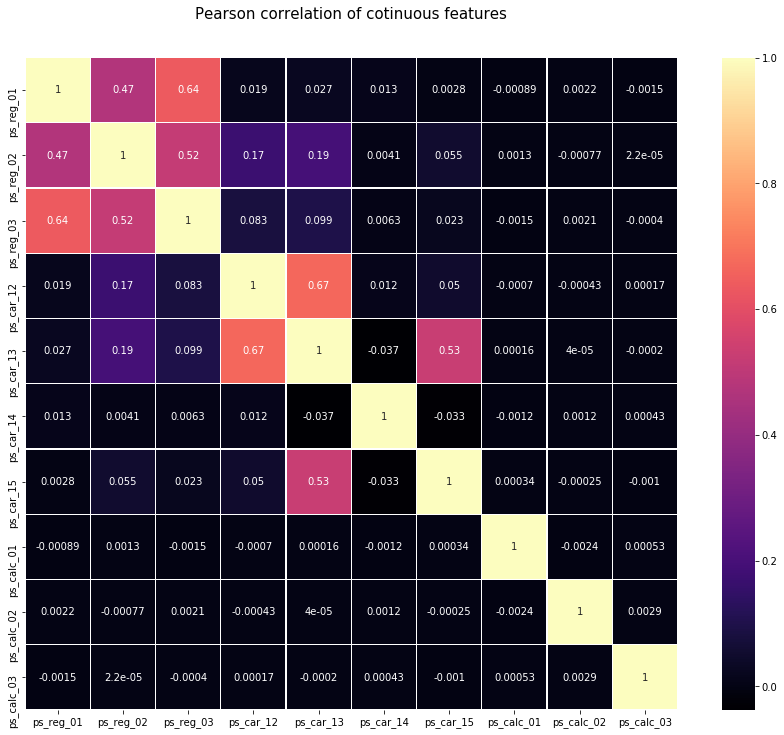

In [17]:
# correlation of float features
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of cotinuous features', y = 1.05, size =15)
sns.heatmap(train_float.corr(),linewidths = 0.1, vmax =1.0, square =True,
           cmap = colormap, linecolor ='white', annot=True)

### Mutual Information Plots
 - 아쉽게도 모든게 다 관련성이 없는것으로 나온다.
  - Mutual information is another useful tool as it allows one to inspect the mutual information between the target variable and the corresponding feature it is calculated against. For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the dependency between two random variables and ranges from zero (where the random variables are independent of each other) to higher values (indicate some dependency). This therefore will help give us an idea of how much information from the target may be contained within the features.

The sklearn implementation of the mutual_info_classif function tells us that it "relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances", where you can go into more detail on the official sklearn page 

In [22]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors =3, random_state = 17)

In [23]:
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

In [26]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list =[]
one_list = []
for col in bin_col :
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [27]:
trace1 = go.Bar(
    x = bin_col,
    y= zero_list,
    name='Zero count'
    )

trace2 = go.Bar(
    x= bin_col,
    y= one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode ='stack',
    title = 'Count of 1 and 0 in binary variables'
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename ='stacked-bar')

Here we observe that there are 4 features : ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros.

### Feature importance via Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=10, random_state=0)
rf.fit(train.drop(['id','target'],axis =1), train.target)
features = train.drop(['id','target'], axis =1).columns.values

In [31]:
### Plot.ly scatter plot of feature importances
trace = go.Scatter(
    y= rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict( sizemode = 'diameter',
                 sizeref = 1,
                size =13,
                  color = rf.feature_importances_,
                  colorscale = 'Portland',
                  showscale = True
                 
                 ),
    text = features

)

data = [trace]
layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [33]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')